In [27]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import fipy as fp
import h5py

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['font.size']=20

In [3]:
path='/home/artem.kays/scripts/lncRNAeffects/RNA_diffusion'
os.chdir(path)
from utils.input_parse import *
from utils.utils import *
from utils.free_energy import *

In [43]:
mesh_f = 'results/hollow_chrom_2D/mesh_n_cells_2500.0_scale_5.0_sigma_chr_0.5.msh2'
dist_f = 'results/hollow_chrom_2D/dist_n_cells_2500.0_scale_5.0_sigma_chr_0.5.hdf5'
spvar_fs = ['results/hollow_chrom_2D/gene_at_chrom_n_cells_2500.0_sigma_chr_0.5_c_DH_0.5_sigma_DH_2.0_chi_pr_1.2/spatial_variables.hdf5',
            'results/hollow_chrom_2D/n_cells_2500.0_sigma_chr_0.5_c_DH_0.5_sigma_DH_2.0_k_p_max_lncRNA_25.0/spatial_variables.hdf5']
k_r = [0.25, 25]

bin_r = np.asarray([(5*np.cos(2*np.pi/9*x), 5*np.sin(2*np.pi/9*x)) for x in range(9)])
mesh = fp.Gmsh2D(mesh_f)

In [90]:
input_parameters = input_parse('input/input_params_diffusion.txt')

with h5py.File(dist_f, 'r') as f:
    d_chr = f['d_chr'][:]
d_chr = fp.CellVariable(mesh=mesh, name=r'$d_{chr}$', value = d_chr)
d_chr_sur = fp.CellVariable(mesh=mesh, name=r'$d_{chr\_sur}$', value = d_chr - input_parameters['sigma_chr'])

spvar='phi_r'
name='RNA'
phi_r_list = []
for i, spvar_f in enumerate(spvar_fs):
    with h5py.File(spvar_f, 'r') as f:
        count = 1
        while np.sum(f[spvar][-count]) == 0.0:
            count = count + 1
        phi_r_list.append(fp.CellVariable(mesh=mesh, name=r'$phi_R$', value = f[spvar][-1]))

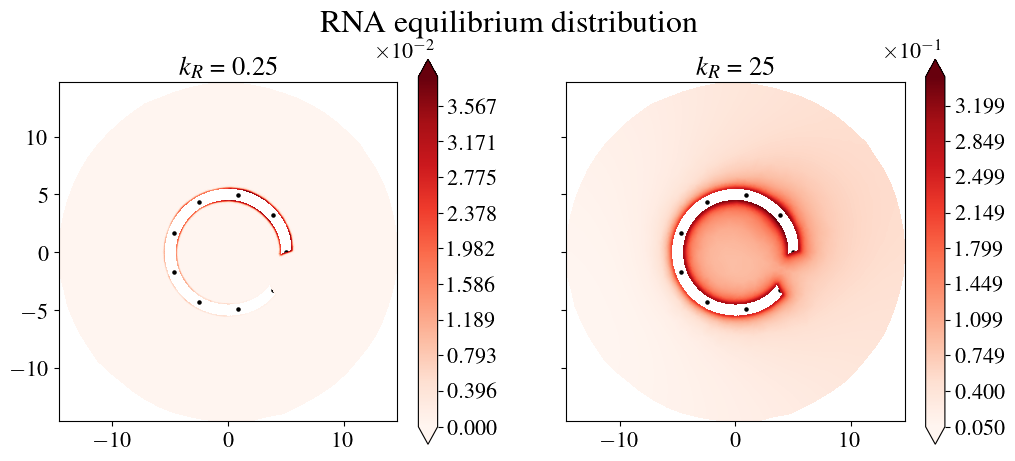

In [91]:
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['font.size']=16

mask=np.any(mesh.exteriorFaces.value[mesh.cellFaceIDs.data], axis=0)
triang = tri.Triangulation(mesh.x.value, mesh.y.value)
triang.set_mask(np.all(mask[triang.triangles], axis=1))

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,5))
plt.suptitle(f'{name} equilibrium distribution', size='x-large')
for i, ax in enumerate(axes):
    ax.scatter(bin_r[:, 0], bin_r[:, 1], c='black', edgecolor='k', s=5)
    cs = ax.tricontourf(triang,
                        phi_r_list[i],
                        levels=np.linspace(phi_r_list[i].min(), phi_r_list[i].max(), 256),
                        cmap="Reds",
                        extend="both")
    cbar=fig.colorbar(cs, ax=ax)
    cbar.formatter.set_powerlimits((0, 0))
    ax.set_title(fr'$k_R$ = {k_r[i]}')
    ax.set_aspect('equal', adjustable='box')

fig.savefig(f'{path}/figures/analysis_2D/{spvar}.png', bbox_inches='tight', dpi=300, format='png')

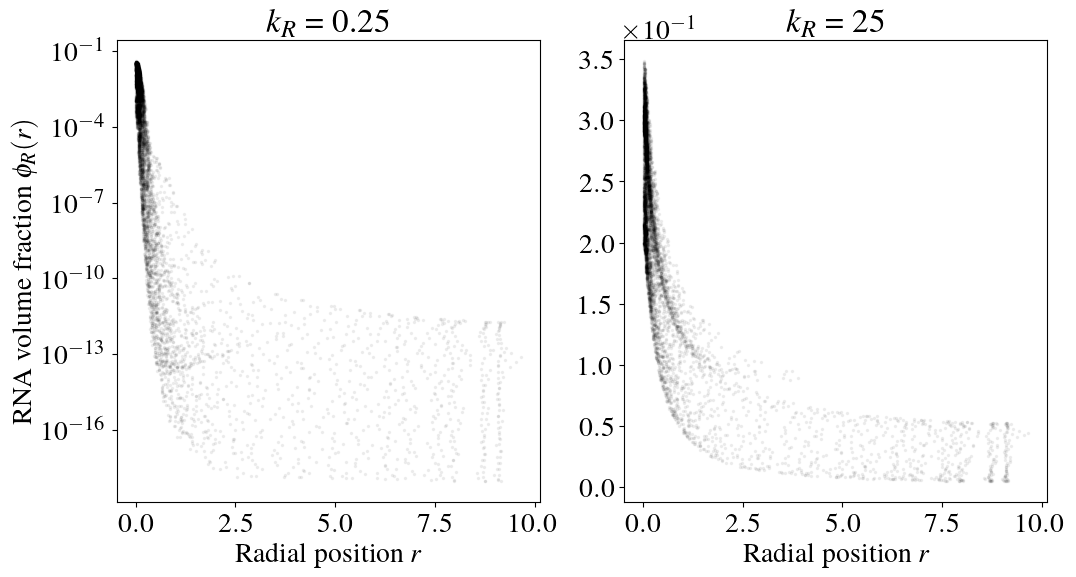

In [96]:
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['font.size']=20

fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12,6))
#plt.suptitle(f'{name} equilibrium distribution', size='x-large')
for i, ax in enumerate(axes):
    ax.scatter(d_chr_sur, phi_r_list[i], s=10, alpha=0.05, c='black', marker='.')
    ax.set_title(fr'$k_R$ = {k_r[i]}')
    ax.set_ylabel('' if i else f'{name} ' + r'volume fraction $\phi_R(r)$')
    ax.set_xlabel(r'Radial position $r$')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

axes[0].set_yscale('log')

fig.savefig(f'{path}/figures/analysis_2D/{spvar}-r.png', bbox_inches='tight', dpi=300, format='png')

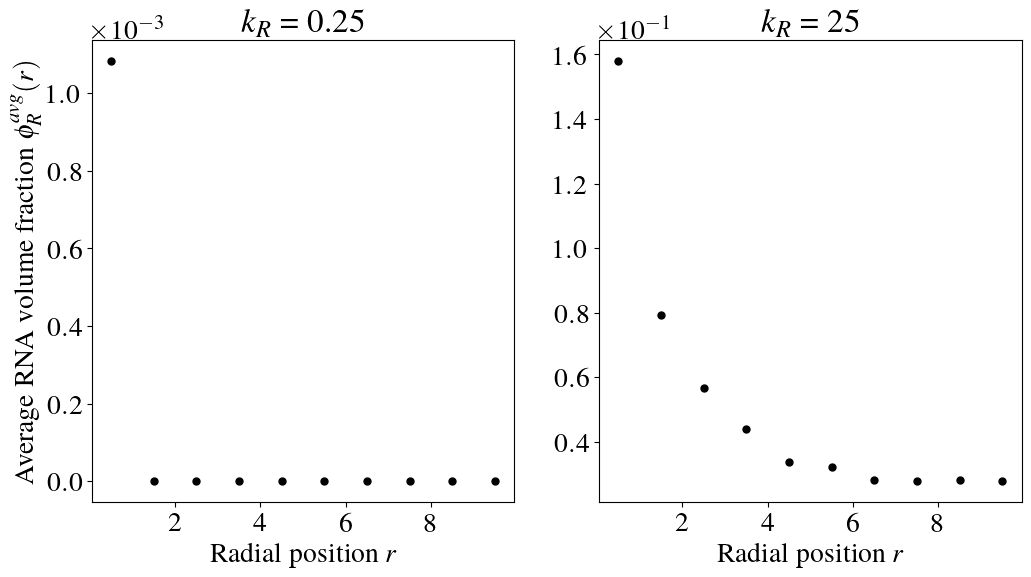

In [93]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12,6))
#plt.suptitle(f'{name} equilibrium distribution', size='x-large')
for i, ax in enumerate(axes):
    d_max=int(max(d_chr_sur))
    l=[av_in_domain(mesh, phi_r_list[i], (d<=d_chr_sur)&(d_chr_sur<d+1))
       for d in np.arange(d_max+1)]
    
    ax.scatter(np.linspace(0, d_max, d_max+1)+0.5,
                l, s=100, c='black', marker='.')
    ax.set_title(fr'$k_R$ = {k_r[i]}')
    ax.set_ylabel('' if i else f'Average {name} ' + r'volume fraction $\phi^{avg}_R(r)$')
    ax.set_xlabel(r'Radial position $r$')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
fig.savefig(f'{path}/figures/analysis_2D/{spvar}_av-r.svg', format='svg')

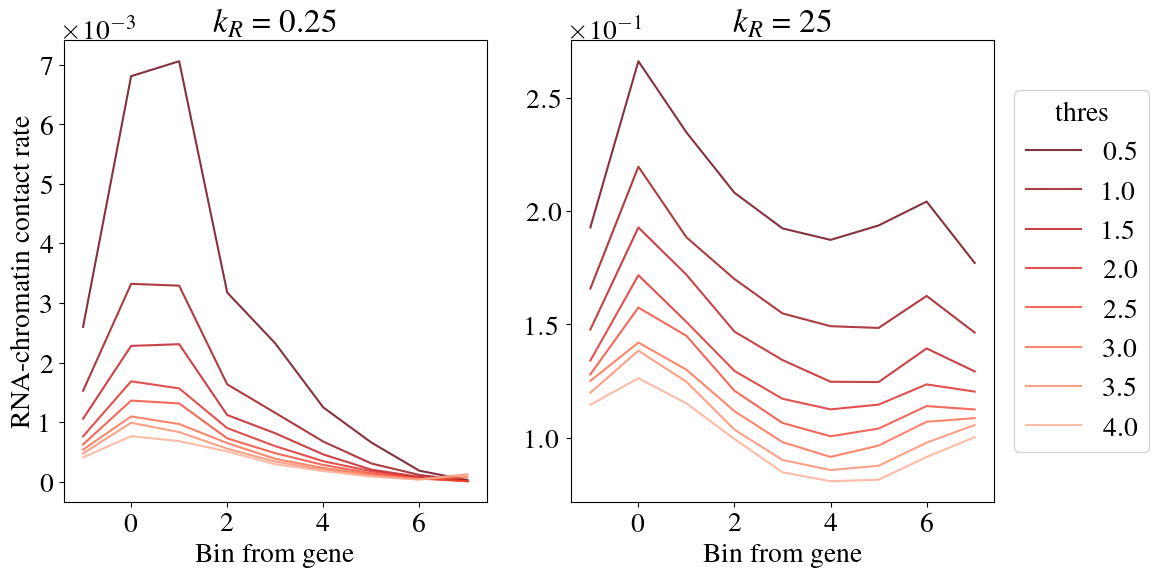

In [94]:
gene_bin = 1
rnachrom_thress = np.linspace(1/2,4,8)
cmap = plt.get_cmap('Reds_r')
color_vals = np.linspace(0.0,0.7,len(rnachrom_thress))

fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(12,6))
#plt.suptitle(f'{name} equilibrium distribution', size='x-large')
with h5py.File(dist_f, 'r') as f:
    for i, ax in enumerate(axes): 
        for j, thres in enumerate(rnachrom_thress):
            l=[av_in_domain(mesh, phi_r_list[i], (f['d_bin'][bin_, :]<=thres+0.5)) for bin_ in range(f['d_bin'].shape[0])]
            ax.plot(np.arange(f['d_bin'].shape[0]) - gene_bin,
                    l,
                    label=str(thres),
                    alpha=0.8, color = cmap(color_vals[j]))
                
        ax.set_title(fr'$k_R$ = {k_r[i]}')
        ax.set_xlabel('Bin from gene')
        ax.set_ylabel('' if i else f'{name}-chromatin contact rate')
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

axes[1].legend(title="thres", loc='right', bbox_to_anchor=(1.4, 0.5))

plt.savefig(f'{path}/figures/analysis_2D/{name}Chrom-bin.png', bbox_inches='tight', dpi=300, format="png")